# Análise Descritiva 4 - Prática 2


Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. 

*Welcome to the jungle*, A vida real é assim :)

In [1]:
# Carregando bibliotecas 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Carregando dados

df_full = pd.read_pickle('./input/base_nfp.pkl')
df = df_full[df_full['Data Emissão'] >= '2020-01-01']
print(df.shape)
df.head()

(86956, 13)


,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Alimentos
64601,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,2020-01-01,21.77,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Farmácia
64602,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,2020-01-01,80.95,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Restaurantes


In [3]:
# Metadados básico (com todas as variáveis)
metadata = pd.DataFrame({'dtype': df.dtypes})
metadata['nunique'] = df.nunique()
metadata

,dtype,nunique
CNPJ emit.,object,16010
Emitente,object,12196
No.,int64,71685
Data Emissão,datetime64[ns],731
Valor NF,float64,28381
Data Registro,datetime64[ns],734
Créditos,float64,7845
Situação do Crédito,category,3
Ano,int64,3
Semestre,int64,2


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

##### Existem dados com valores errados de semestre (veja abaixo)

In [4]:
# Utilizaremos np.where 

# Create an array of numbers
numbers = np.array([3, 7, 2, 8, 5])

# Use np.where to categorize numbers
categories = np.where(numbers > 5, 'High', 'Low')

print(categories)

['Low' 'High' 'Low' 'High' 'Low']


In [33]:
# pegando uma amostra
dfsample = df.sample(200, random_state=1234)
# Verificando
dfsample['Semestre(deveria ser)'] = np.where(dfsample['Data Emissão'].dt.quarter.isin([1, 2]), 1, 2)
# dfsample['Trimestre'] = dfsample['Data Emissão'].dt.quarter
# Ou
dfsample['Trimestre'] = (dfsample['Data Emissão'].dt.month + 2) // 3

# Exemplo 
dfsample_10 = dfsample.head(10) 
(dfsample_10[['Data Emissão', 'Semestre', 'Semestre(deveria ser)', 'Trimestre']]
    .style.highlight_between(subset='Data Emissão', left='2020-02-12 00:00:00', right='2020-02-12 00:00:00'))

,Data Emissão,Semestre,Semestre(deveria ser),Trimestre
181779,2021-08-16 00:00:00,2,2,3
100911,2020-06-29 00:00:00,1,1,2
124526,2020-02-12 00:00:00,2,1,1
122628,2020-12-16 00:00:00,2,2,4
163300,2021-12-28 00:00:00,2,2,4
176099,2021-09-28 00:00:00,2,2,3
123266,2020-12-12 00:00:00,2,2,4
131252,2020-09-10 00:00:00,2,2,3
104063,2020-05-28 00:00:00,1,1,2
153467,2021-03-27 00:00:00,1,1,1


#### Voltando para a análise

In [6]:
# Definindo uma cópia do DataFrame

df2 = df.copy()
df2.head(2)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado


In [7]:
# Dias da semana
df2['Data Emissão'].dt.day_name().unique()

array(['Wednesday', 'Tuesday', 'Monday', 'Sunday', 'Saturday', 'Friday',
       'Thursday'], dtype=object)

In [8]:
# Dias do mês
df2['Data Emissão'].dt.day.unique()

array([ 1, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13,  6, 31,  5,  4,  3,  2, 12, 11, 10,  9,  8,  7],
      dtype=int32)

In [9]:
# Trimestre
# (df2['Data Emissão'].dt.month + 2) // 3

# ou
print(df2['Data Emissão'].dt.quarter.unique())

# para obter os trimestres juntamente aos anos
df2['Data Emissão'].dt.to_period('Q').unique()

[1 2 4 3]


<PeriodArray>
['2020Q1', '2020Q2', '2020Q4', '2020Q3', '2021Q2', '2021Q4', '2021Q3',
 '2021Q1']
Length: 8, dtype: period[Q-DEC]

In [10]:
# Sabendo que:
dias = df2['Data Emissão'].dt.dayofweek.unique()
print(dias)
# Podemos fazer uma divisão inteira de dias//5, quanto o resto não for 0,
# temos os dias do final de semana. Assim,
dias//5

[2 1 0 6 5 4 3]


array([0, 0, 0, 1, 1, 0, 0], dtype=int32)

In [11]:
# Adicionando ao data frame

df2['Dia da semana'] = df2['Data Emissão'].dt.day_name()
df2['Fim de semana'] = (df2['Data Emissão'].dt.dayofweek) // 5 
df2['Dia do mês'] = df2['Data Emissão'].dt.day
df2['Trimestre'] = df2['Data Emissão'].dt.quarter
df2['AnoTrimestre'] = df2['Data Emissão'].dt.to_period('Q')

df2.head(2)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,Dia da semana,Fim de semana,Dia do mês,Trimestre,AnoTrimestre
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido,Wednesday,0,1,1,2020Q1
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado,Wednesday,0,1,1,2020Q1


In [12]:
# Criando as categorias

categorias = [5, 10, 20, 50, 55, 60]

for cat in categorias:
    col_name = f'Valor NF com {cat} categorias'
    df2[col_name] = pd.qcut(df2['Valor NF'], cat, labels=False)

df2.head(2)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,Fim de semana,Dia do mês,Trimestre,AnoTrimestre,Valor NF com 5 categorias,Valor NF com 10 categorias,Valor NF com 20 categorias,Valor NF com 50 categorias,Valor NF com 55 categorias,Valor NF com 60 categorias
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,...,0,1,1,2020Q1,2,5,11,27,30,33
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,...,0,1,1,2020Q1,0,1,3,9,10,11


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [13]:
# Gerando metadados

metadados = pd.DataFrame({'dtype': df2.dtypes})
metadados['papel'] = 'covariavel'
# Definindo variável resposta (target)
metadados.loc['flag_credito', 'papel'] = 'resposta'
# Definindo as categorias/componentes únicas por variável
metadados['nunique'] = df2.nunique()

# Removendo dados irrelevantes (na análise)
metadados.drop(index=['Data Emissão',
    'CNPJ emit.',
    'Emitente',
    'No.',
    'Valor NF',
    'Data Registro',
    'Créditos',
    'Situação do Crédito',
    'Retorno'], inplace=True)

metadados

,dtype,papel,nunique
Ano,int64,covariavel,3
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
Dia da semana,object,covariavel,7
Fim de semana,int32,covariavel,2
Dia do mês,int32,covariavel,31
Trimestre,int32,covariavel,4
AnoTrimestre,period[Q-DEC],covariavel,8
Valor NF com 5 categorias,int64,covariavel,5


In [14]:
# índices das covariaveis
metadados[metadados.papel == 'covariavel'].index

Index(['Ano', 'Semestre', 'categoria', 'Dia da semana', 'Fim de semana',
       'Dia do mês', 'Trimestre', 'AnoTrimestre', 'Valor NF com 5 categorias',
       'Valor NF com 10 categorias', 'Valor NF com 20 categorias',
       'Valor NF com 50 categorias', 'Valor NF com 55 categorias',
       'Valor NF com 60 categorias'],
      dtype='object')

##### Definindo a função para o *information value* (IV)

In [15]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rotulo_evento = tab.columns[0]
    rotulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rotulo_evento]/tab.loc['total', rotulo_evento]
    tab['pct_nao_evento'] = tab[rotulo_nao_evento]/tab.loc['total', rotulo_nao_evento]
    tab['woe'] = np.log(tab['pct_evento']/tab.pct_nao_evento)
    tab['iv'] = (tab.pct_evento - tab.pct_nao_evento) * tab.woe

    return tab['iv'].sum()

In [16]:
pd.api.types.is_numeric_dtype

<function pandas.core.dtypes.common.is_numeric_dtype(arr_or_dtype) -> 'bool'>

In [17]:
# Preenchendo os metadados
for var in metadados[metadados.papel == 'covariavel'].index:
    if pd.api.types.is_numeric_dtype(df2[var]):
        if metadados.loc[var, 'nunique'] > 50:
            metadados.loc[var, 'IV'] = IV(pd.qcut(df2[var], 5, duplicates='drop'), df2.flag_credito)
        else:
            metadados.loc[var, 'IV'] = IV(df2[var], df2['flag_credito'])
    else:
        metadados.loc[var, 'IV'] = IV(df2[var], df2.flag_credito)

metadados

,dtype,papel,nunique,IV
Ano,int64,covariavel,3,inf
Semestre,int64,covariavel,2,0.004874
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.278826
Dia da semana,object,covariavel,7,0.005878
Fim de semana,int32,covariavel,2,0.004599
Dia do mês,int32,covariavel,31,0.015128
Trimestre,int32,covariavel,4,0.003554
AnoTrimestre,period[Q-DEC],covariavel,8,0.009925
Valor NF com 5 categorias,int64,covariavel,5,0.038990


##### <span style='color:red'> Relembrando as recomendações de *Naeem Siddiqi* </span>

Naeem Siddiqi recomenda as seguintes regras de bolso para interpretar o IV:

|Faixa|Poder preditivo|
|:-|:-|
|0 a 0,02| Inútil |
|0,02 a 0,1| Fraco |
|0,1 a 0,3| Médio |
|0,3 a 0,5| Forte |
|0,5 ou mais| Suspeito de tão alto |

Vamos considerar tais recomendações, mas é importante lembrar que elas são válidas apenas para análise de crédito. Tais valores podem e provavelmente serão muito deferentes para outros contextos.

In [18]:
# Aplicando as recomendações 
metadados.loc[metadados['IV'] < .02, "Poder preditivo"] = 'Irrelevante'
metadados.loc[(metadados['IV'] >= .02) & (metadados['IV'] < .1), "Poder preditivo"] = 'Fraco'
metadados.loc[(metadados['IV'] >= .1) & (metadados['IV'] < .3), "Poder preditivo"] = 'Médio'
metadados.loc[(metadados['IV'] >= .3) & (metadados['IV'] < .5), "Poder preditivo"] = 'Forte'
metadados.loc[(metadados['IV'] >= .5), "Poder preditivo"] = 'Suspeito'

In [19]:
metadados

,dtype,papel,nunique,IV,Poder preditivo
Ano,int64,covariavel,3,inf,Suspeito
Semestre,int64,covariavel,2,0.004874,Irrelevante
flag_credito,int64,resposta,2,NaN,NaN
categoria,object,covariavel,9,0.278826,Médio
Dia da semana,object,covariavel,7,0.005878,Irrelevante
Fim de semana,int32,covariavel,2,0.004599,Irrelevante
Dia do mês,int32,covariavel,31,0.015128,Irrelevante
Trimestre,int32,covariavel,4,0.003554,Irrelevante
AnoTrimestre,period[Q-DEC],covariavel,8,0.009925,Irrelevante
Valor NF com 5 categorias,int64,covariavel,5,0.038990,Fraco


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

> A variável `categoria` e a categorização de `Valor NF` em  50 categorias tem os maiores valores preditivos.

> O número de categorias aparenta desempenhar um papel importante, mas parece haver um range específico na quantidade de categorias que desempenha uma capacidade preditiva maior, uma vez que com o aumento no número de categorias (55 e 60, feitos exclusivamente para testar essa hipótese) houve uma queda no poder preditivo.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [20]:
# quantidade de notas registradas por trimestre

tab = df2.groupby(['AnoTrimestre', 'flag_credito']).size().unstack()
tab['Total'] = tab.sum(axis=1)
tab

flag_credito,0,1,Total
AnoTrimestre,,,
2020Q1,6014,4570,10584
2020Q2,6049,3561,9610
2020Q3,6289,4427,10716
2020Q4,6346,4956,11302
2021Q1,5507,4576,10083
2021Q2,6118,4670,10788
2021Q3,6329,5293,11622
2021Q4,6986,5265,12251


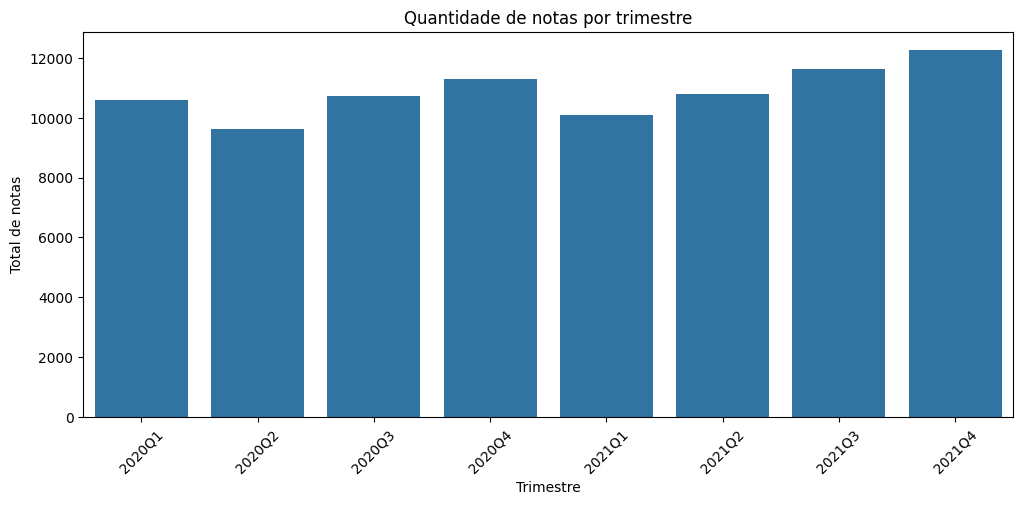

In [21]:
# Gráfico do total
plt.figure(figsize=[12,5])
sns.barplot(data=tab, x='AnoTrimestre', y='Total')
plt.title("Quantidade de notas por trimestre")
plt.xlabel('Trimestre')
plt.ylabel('Total de notas')
plt.tick_params('x', rotation=45)
plt.show()

In [22]:
# Soma por trimestre
tab[1].groupby(level=0).sum()

AnoTrimestre
2020Q1    4570
2020Q2    3561
2020Q3    4427
2020Q4    4956
2021Q1    4576
2021Q2    4670
2021Q3    5293
2021Q4    5265
Freq: Q-DEC, Name: 1, dtype: int64

In [23]:
# Notas por categoria e período, bem como proporção evento
tab2 = df2.groupby(['AnoTrimestre', 'categoria', 'flag_credito']).size().unstack()
tab2['total'] = tab2.sum(axis=1)
tab2['taxa_evento'] = tab2[1] / tab2['total']

tab2#.unstack().T

flag_credito                  0     1  total  taxa_evento
AnoTrimestre categoria                                   
2020Q1       Alimentos      202   499    701     0.711840
             Auto posto      66    22     88     0.250000
             Construção    1089   910   1999     0.455228
             Farmácia       992   226   1218     0.185550
             Mercado       1939  1465   3404     0.430376
...                         ...   ...    ...          ...
2021Q4       Mercado       1837  1697   3534     0.480192
             Restaurantes    90   167    257     0.649805
             Varejo         653    86    739     0.116373
             Vestuário      270    68    338     0.201183
             não definido  1872   952   2824     0.337110

[72 rows x 4 columns]

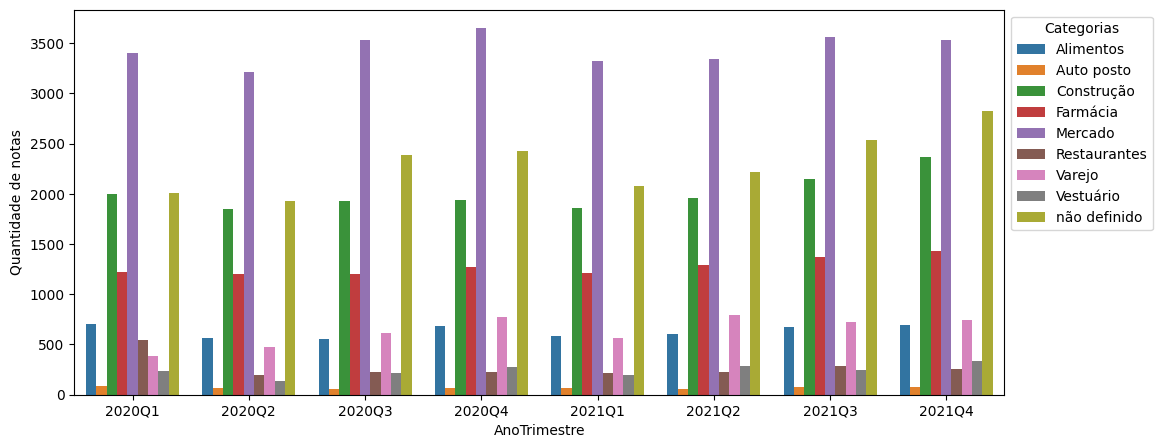

In [24]:
# Visualização gráfica
plt.figure(figsize=[12,5])
sns.barplot(data=tab2, x='AnoTrimestre', y='total', hue='categoria')
plt.legend(title='Categorias', bbox_to_anchor=(1, 1))
plt.ylabel('Quantidade de notas')

plt.show()

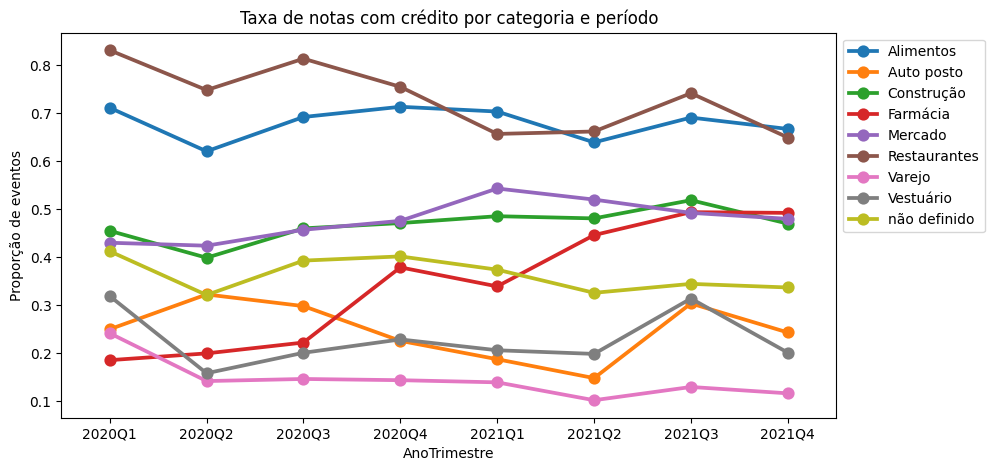

In [25]:
# Proporção de notas com crédito por categoria por período
plt.figure(figsize=[10,5])
sns.pointplot(data=tab2, x='AnoTrimestre', y='taxa_evento', hue='categoria')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Taxa de notas com crédito por categoria e período')
plt.ylabel('Proporção de eventos')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [26]:
# Adicionando a proporção de não eventos
tab2['prop_evento'] = tab2[1] / tab[1].groupby(level=0).sum()
tab2['prop_nao_evento'] = tab2[0] / tab2[0].groupby(level=0).sum()

# Calculando o WOE
tab3 = pd.DataFrame()
tab3['woe'] = np.log(tab2['prop_evento'] / tab2['prop_nao_evento'])

# Calculando o IV
tab3['IV'] = (tab2['prop_evento'] - tab2['prop_nao_evento']) * tab3['woe']

# Análise segundo as recomendações de Naeem Siddiqi
tab3.loc[tab3['IV'] < .02, "Poder preditivo"] = 'Irrelevante'
tab3.loc[(tab3['IV'] >= .02) & (tab3['IV'] < .1), "Poder preditivo"] = 'Fraco'
tab3.loc[(tab3['IV'] >= .1) & (tab3['IV'] < .3), "Poder preditivo"] = 'Médio'
tab3.loc[(tab3['IV'] >= .3) & (tab3['IV'] < .5), "Poder preditivo"] = 'Forte'
tab3.loc[(tab3['IV'] >= .5), "Poder preditivo"] = 'Suspeito'

tab3.unstack().T

AnoTrimestre                       2020Q1       2020Q2       2020Q3  \
                categoria                                             
woe             Alimentos        1.178915     1.023631     1.163316   
                Auto posto      -0.824035    -0.212086    -0.504586   
                Construção       0.095006      0.12077     0.192115   
                Farmácia        -1.204611    -0.858533    -0.901148   
                Mercado          -0.00574     0.224354      0.18037   
                Restaurantes     1.872965     1.621638     1.828346   
                Varejo          -0.869104    -1.269343    -1.412509   
                Vestuário       -0.483109     -1.14128    -1.029384   
                não definido    -0.078473    -0.217533    -0.083109   
IV              Alimentos        0.089128     0.064278     0.069198   
                Auto posto       0.005076     0.000281     0.001272   
                Construção       0.001715      0.00284     0.006736   
                Farmácia         0.139127     0.078347     0.079483   
                Mercado          0.000011     0.017258     0.010873   
                Restaurantes     0.156087     0.053351     0.063782   
                Varejo           0.024755     0.061104     0.089199   
                Vestuário        0.004924     0.015024     0.017991   
                não definido     0.001162     0.009189     0.001526   
Poder preditivo Alimentos           Fraco        Fraco        Fraco   
                Auto posto    Irrelevante  Irrelevante  Irrelevante   
                Construção    Irrelevante  Irrelevante  Irrelevante   
                Farmácia            Médio        Fraco        Fraco   
                Mercado       Irrelevante  Irrelevante  Irrelevante   
                Restaurantes        Médio        Fraco        Fraco   
                Varejo              Fraco        Fraco        Fraco   
                Vestuário     Irrelevante  Irrelevante  Irrelevante   
                não definido  Irrelevante  Irrelevante  Irrelevante   

AnoTrimestre                       2020Q4       2021Q1       2021Q2  \
                categoria                                             
woe             Alimentos        1.161474     1.051415     0.844006   
                Auto posto      -0.984918    -1.281142    -1.479124   
                Construção       0.132608     0.128036     0.194607   
                Farmácia        -0.246405    -0.480891     0.054574   
                Mercado          0.151235     0.359575      0.35151   
                Restaurantes     1.375166     0.836378     0.943805   
                Varejo          -1.536998    -1.636041    -1.904956   
                Vestuário       -0.967974    -1.162878    -1.124952   
                não definido    -0.150345    -0.328967    -0.456396   
IV              Alimentos        0.078728     0.061136     0.039868   
                Auto posto       0.004667     0.008738     0.008587   
                Construção       0.003037      0.00303     0.006957   
                Farmácia         0.006682     0.026736     0.000359   
                Mercado           0.00744     0.042861     0.038794   
                Restaurantes     0.035868     0.014502     0.018888   
                Varejo            0.12567     0.115307     0.188965   
                Vestuário         0.01977     0.022354     0.028561   
                não definido     0.004799     0.021787     0.040867   
Poder preditivo Alimentos           Fraco        Fraco        Fraco   
                Auto posto    Irrelevante  Irrelevante  Irrelevante   
                Construção    Irrelevante  Irrelevante  Irrelevante   
                Farmácia      Irrelevante        Fraco  Irrelevante   
                Mercado       Irrelevante        Fraco        Fraco   
                Restaurantes        Fraco  Irrelevante  Irrelevante   
                Varejo              Médio        Médio        Médio   
                Vestuár

In [27]:
# Tab completa
tab_full = pd.concat([tab2, tab3], axis=1)

tab_full.reset_index(inplace=True)
tab_full.head()

,AnoTrimestre,categoria,0,1,total,taxa_evento,prop_evento,prop_nao_evento,woe,IV,Poder preditivo
0,2020Q1,Alimentos,202,499,701,0.711840,0.109190,0.033588,1.178915,0.089128,Fraco
1,2020Q1,Auto posto,66,22,88,0.250000,0.004814,0.010974,-0.824035,0.005076,Irrelevante
2,2020Q1,Construção,1089,910,1999,0.455228,0.199125,0.181077,0.095006,0.001715,Irrelevante
3,2020Q1,Farmácia,992,226,1218,0.185550,0.049453,0.164948,-1.204611,0.139127,Médio
4,2020Q1,Mercado,1939,1465,3404,0.430376,0.320569,0.322414,-0.005740,0.000011,Irrelevante


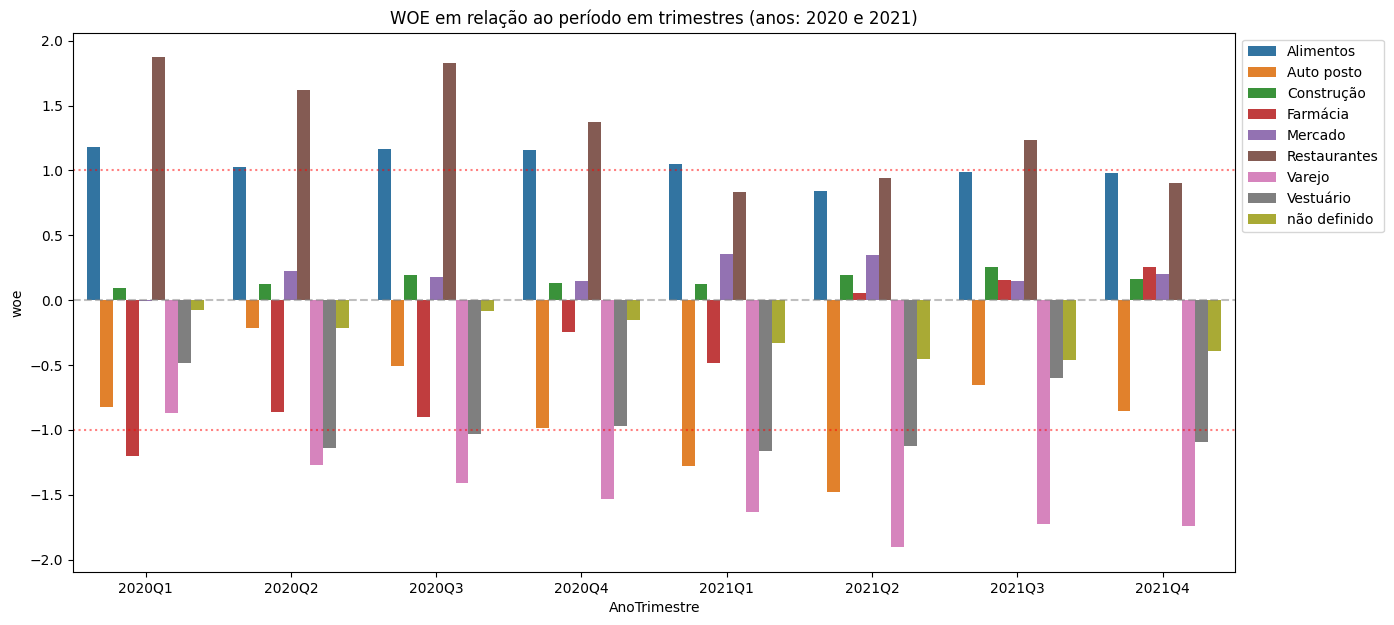

In [28]:
# Graficamente (visualização do WOE)

fig, ax = plt.subplots(figsize=[15,7])
sns.barplot(data=tab3, x='AnoTrimestre', y='woe', hue='categoria', ax=ax)
ax.set_title('WOE em relação ao período em trimestres (anos: 2020 e 2021)')

# Linhas de referência
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)

# plt.grid()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

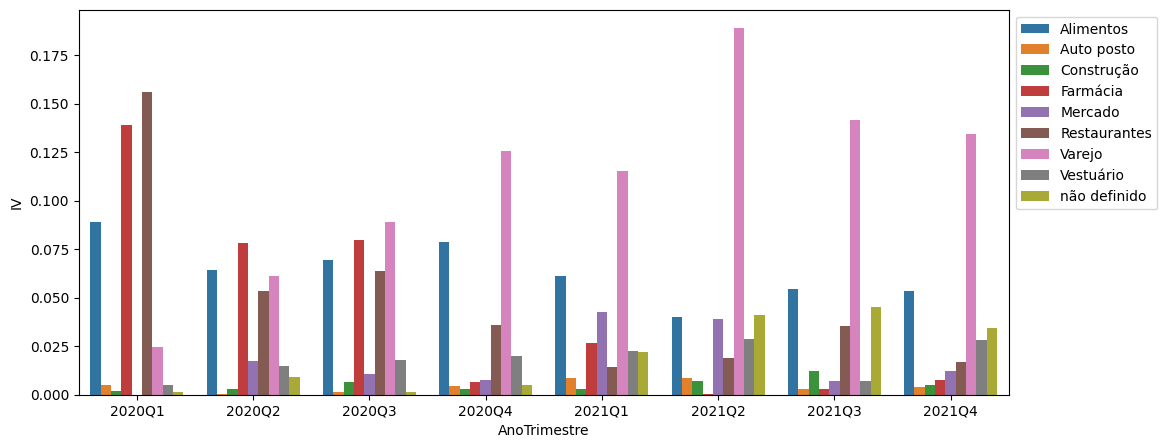

In [29]:
# Visualização gráfica do IV

plt.figure(figsize=[12,5])
sns.barplot(data=tab3, x='AnoTrimestre', y='IV', hue='categoria')
plt.legend(bbox_to_anchor=(1,1))

plt.show()

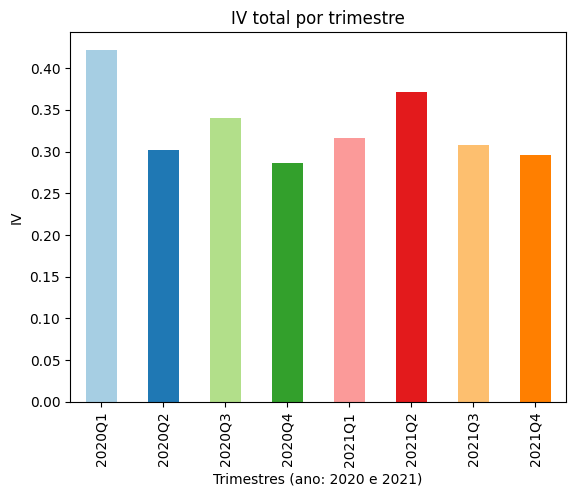

In [30]:
# Avaliando o IV total sem descrição por categoria

IV_total_trimestre = tab3.IV.groupby(level=0).sum()
palette = sns.color_palette("Paired", len(IV_total_trimestre))
# Plot
IV_total_trimestre.plot.bar(color=palette)
plt.title('IV total por trimestre')
plt.xlabel('Trimestres (ano: 2020 e 2021)')
plt.ylabel('IV')
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

#### <span style='color:red'> Insights </span>
- As categorias que apresentaram retorno maior que zero foram `Alimento`, `Restaurantes` e `Construção`. A categoria `mercado` começa a se destacar mais a partir do segundo trimestre de 2020, já a categoria `farmácia` passa a ter valores positivos de `woe` a partir do segundo trimestres de 2021 (vide gráfico de `woe`);
- É válido destacar que a categoria `Farmácia` possui o maior crescimento no número de eventos ao longo dos períodos analisados, e isso pode ser evidenciado pelo gráfico da taxa em função dos períodos;
- As categorias  `Alimento` e `Restaurantes` são as mais estáveis ao longo do tempo;
- `Varejo` possui alto IV, porém um `woe` negativo, ou seja, apesar de vender muito não gera créditos. Isso pode ocorrer devido a venda de produtos não incentivados, como cigarro e bebidas alcoólicas, em lojas de varejo e as notas de tais produtos não dão retorno.